In [1]:
import sys,os
sys.path.append(os.getcwd())
sys.path.append(os.getcwd()[:-8]+'src')
from Algorithms import *
from metrics import *
import seaborn as sns
import matplotlib
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 
plt.style.use('default')#../misc/report.mplstyle')
cust_cmap =sns.color_palette("flare_r", as_cmap=True)
cust_cmap2 = matplotlib.cm.get_cmap('Set2')#.colors
plt.rcParams["font.family"] = "Arial"
cm = 1/2.54

In [44]:
#Load dataset
resp = np.load('/Users/constb/Data/PachitariuData/Drifting/gratings_drifting_GT1_2019_04_12_1.npy',allow_pickle=True).item()


/var/folders/16/v7n9r3kd5jb_n_2jxmxrldyw0000gp/T/ipykernel_23999/1659284312.py:20: RuntimeWarning: Mean of empty slice
  avg_responses_lowres[c] = np.nanmean(responses[:,bin_indx],1)


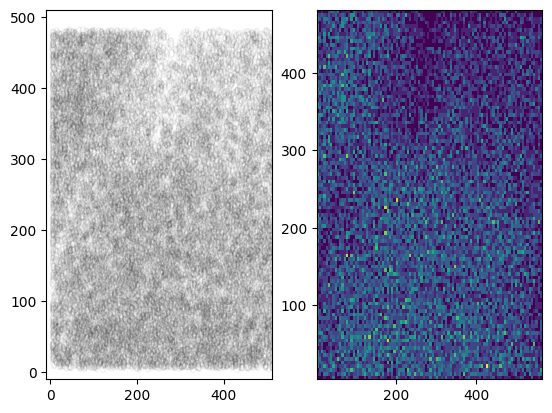

In [45]:
responses = resp['sresp']
indices=  resp['istim']
if len(responses.T)>len(indices):
    responses = responses[:,:len(indices)]
uniq_ids = np.unique(indices)
stim_res = 126
stim_lowres = 32
stim_bins = np.linspace(0,2*np.pi+2*np.pi/(stim_res+4),stim_res+2)[:-1]#np.linspace(uniq_ids[0],uniq_ids[-1],61)# We added 2*np.pi/60 to get degrees of distance 6 apart.
stim_bins_lowres = np.linspace(0,2*np.pi+2*np.pi/12,stim_lowres)[:-1]#np.linspace(uniq_ids[0],uniq_ids[-1],61)
stim_bins_degrees = (180*stim_bins/np.pi)

#responses = responses/np.max(responses)
avg_responses = np.zeros([len(stim_bins)-1,len(responses)])
avg_responses_lowres = np.zeros([len(stim_bins_lowres)-1,len(responses)])
for c in range(len(stim_bins)-1):
    bin_indx = np.where(np.logical_and(stim_bins[c]<indices,indices<stim_bins[c+1]))[0]
    avg_responses[c] = np.nanmean(responses[:,bin_indx],1)
for c in range(len(stim_bins_lowres)-1):
    bin_indx = np.where(np.logical_and(stim_bins_lowres[c]<indices,indices<stim_bins_lowres[c+1]))[0]
    avg_responses_lowres[c] = np.nanmean(responses[:,bin_indx],1)

#rand_idx = np.random.choice(np.arange(0,len(avg_responses)),50,replace=False)
#print(np.shape(avg_responses))
#avg_responses = avg_responses[rand_idx,:]
#avg_responses_lowres = avg_responses_lowres[rand_idx,:]
#print(np.shape(avg_responses))

response_locations = extract_cell_RFs(resp)

fig, (ax1,ax2) = plt.subplots(1,2)
for i in range(len(response_locations[0])):
    c = plt.Circle(response_locations[0][i],response_locations[1][i],fill=False,alpha=0.05)
    ax1.add_patch(c)
ax1.set_xlim(-10,510)
ax1.set_ylim(-10,510)
_ = ax2.hist2d(response_locations[0][:,0],response_locations[0][:,1],100)

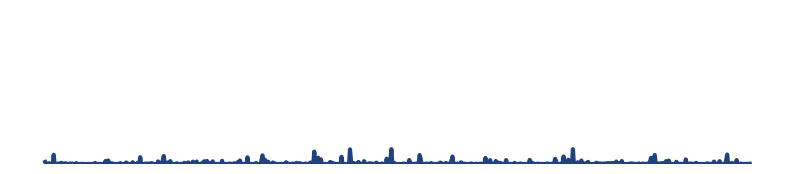

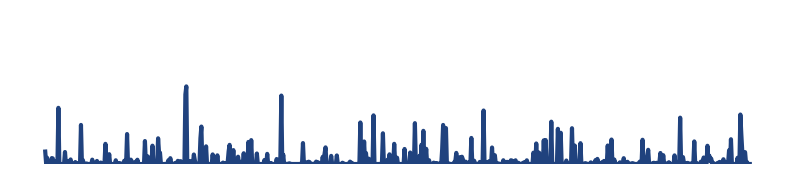

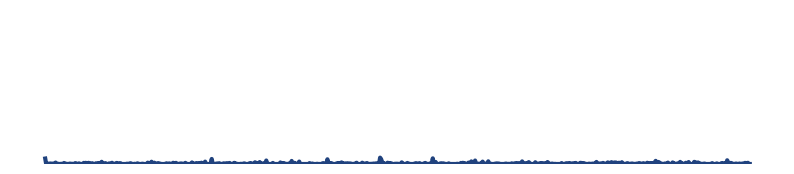

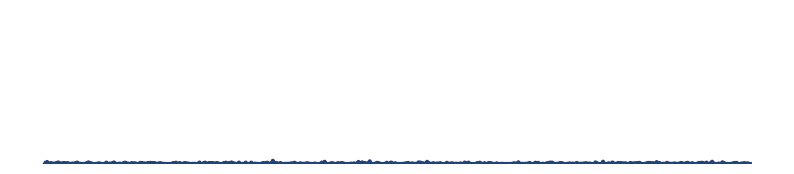

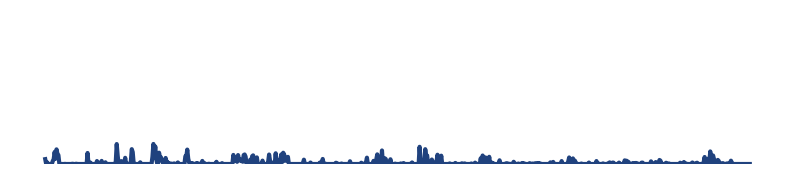

In [46]:
rand_cls = np.random.randint(0,len(responses),5)
max_rcell = np.max(responses[rand_cls])
for c,rcell in enumerate(rand_cls):
    plt.figure(figsize=(10,2))
    plt.plot(responses[rcell,:750],color='#20427eff',linewidth=3)
    plt.ylim(0,max_rcell+50)
    plt.axis('off')
    #plt.savefig('/Users/constb/Figures/NeuralHomology/cell_trace_'+str(c)+'.png',dpi=300,transparent=True)


In [47]:
#optionally select cells in a specific subregion of the image
cell_filter=False
if cell_filter:
    center_limits_high = [275,275]
    center_limits_low = [225,225]
    indx = np.where(np.logical_and(center_limits_low[1]<response_locations[0][:,1],
                                   (np.logical_and(center_limits_low[0]<response_locations[0][:,0],
                                                   np.logical_and(response_locations[0][:,0]<center_limits_high[0],response_locations[0][:,1]<center_limits_high[1])))))[0]
    avg_responses = avg_responses[:,indx]
    avg_responses_lowres = avg_responses_lowres[:,indx]

1 significant 1-cocycles


(array([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        2., 1., 0., 0., 0., 2., 0., 1.]),
 array([0.4132048 , 0.41388701, 0.41456922, 0.41525143, 0.41593364,
        0.41661584, 0.41729805, 0.41798026, 0.41866247, 0.41934468,
        0.42002689, 0.4207091 , 0.42139131, 0.42207352, 0.42275572,
        0.42343793, 0.42412014, 0.42480235, 0.42548456, 0.42616677,
        0.42684898, 0.42753119, 0.42821339, 0.4288956 , 0.42957781,
        0.43026002]),
 <BarContainer object of 25 artists>)

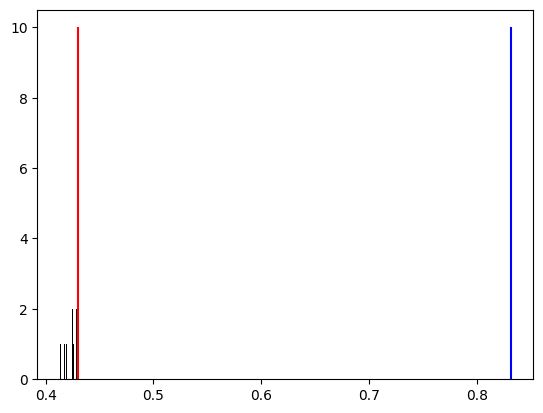

In [48]:
dim_red = 0
metric_used = geodesic_knn(k=4,adaptive=True).fit#pairwise_distances#geodesic#geodesic_knn(k=5,adaptive=True).fit#
Homologizer = Persistent_Homology()
pvalue_hom = Homologizer.perm_test(avg_responses,metric_used,n_perms=10,pval=100)
hom_data = Homologizer(avg_responses,metric_used,False,dim_red,[1,None])
cycle_lengths = hom_data[1][1][:,1]-hom_data[1][1][:,0]

plt.figure()
plt.vlines(pvalue_hom[1],0,10,'b')
plt.vlines(pvalue_hom[0],0,10,'r')
plt.hist(pvalue_hom[2],25,color='k')


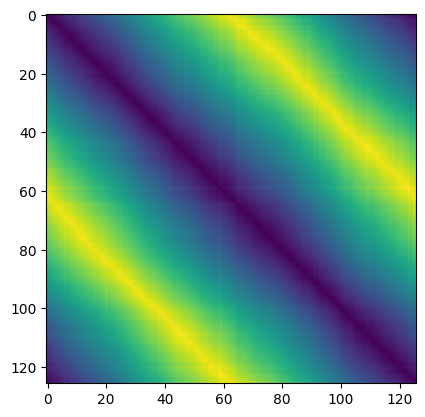

In [49]:
plt.imshow(hom_data[0])

Max cycle index is: 0


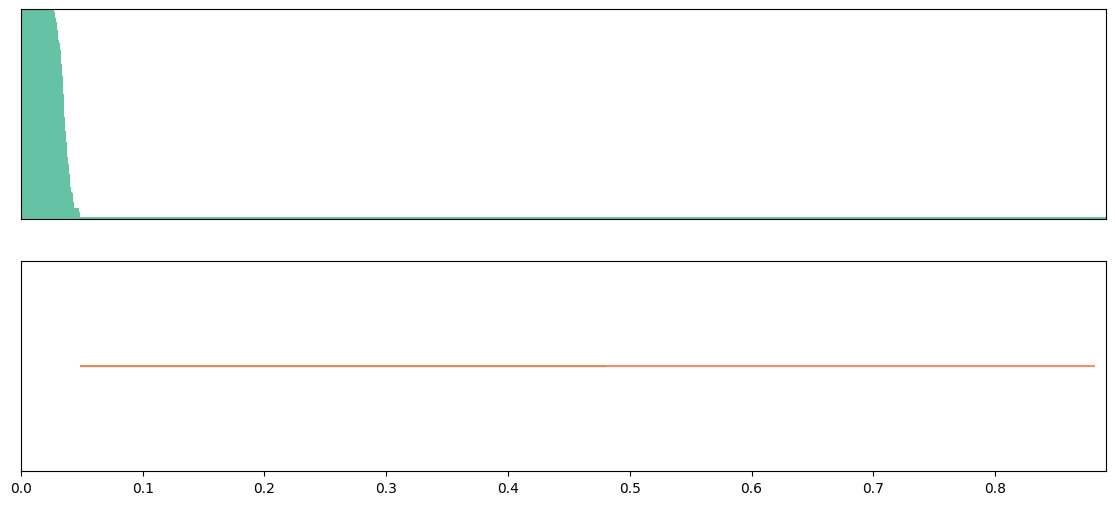

In [50]:
max_cycle = np.argsort(cycle_lengths).astype(int)[-1]
print('Max cycle index is: ' + str(max_cycle))
dmult=0.5
hom_crossection = hom_data[1][1][max_cycle][0]+ dmult*(hom_data[1][1][max_cycle][1]-hom_data[1][1][max_cycle][0])

Homologizer.barcode_plot(hom_data[1],2,pval=pvalue_hom[0])
#plt.vlines(hom_crossection,-1,2,'k',linewidth=5)
#plt.savefig('barcode_geodesic.png',dpi=1000)

/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


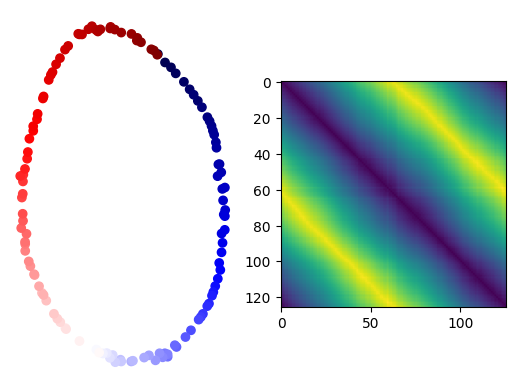

In [51]:
reducer = umap.UMAP(n_neighbors=50,min_dist=0,n_components=2,metric='precomputed')#PCA(n_components=2)#Random_Projector(n_components=2)#PCA(n_components=2)#
ori_mfld = reducer.fit_transform(hom_data[0])

fig = plt.figure()
plt.subplot(121)
plt.scatter(ori_mfld[:,0],ori_mfld[:,1],cmap='seismic',c=stim_bins[:-1])
plt.axis('off')

plt.subplot(122)
plt.imshow(hom_data[0])

#plt.savefig('PCA_manifold_euclid.png',dpi=1000)

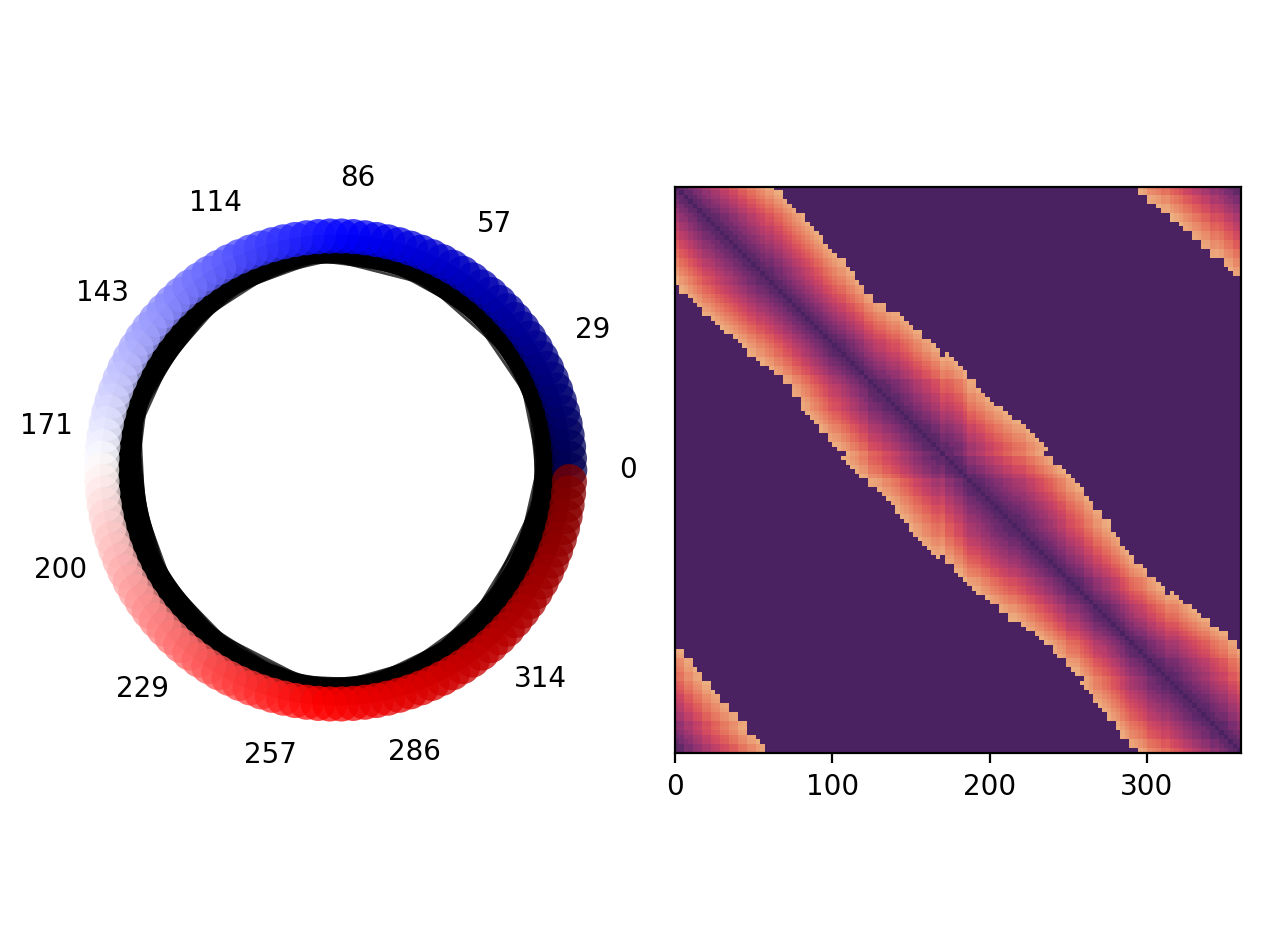

In [52]:
edge_dist = np.copy(hom_data[0])
edge_dist[edge_dist>hom_crossection] = 0

BA = Barcode_Analyzer()

plt.figure(dpi=200)
plt.subplot(121)
BA.plotCocycle2D(hom_data[0],ori_mfld[:,:2],hom_crossection,labels=stim_bins_degrees,node_cmap='seismic')
plt.subplot(122)
plt.imshow(edge_dist, extent=[0,360,360,0],cmap=cust_cmap)
plt.yticks([])
plt.tight_layout()
#plt.savefig('Nmanifold_euclid.png')

### Extract different tunning curves to see if they generate different manifolds

3024
282
20
53


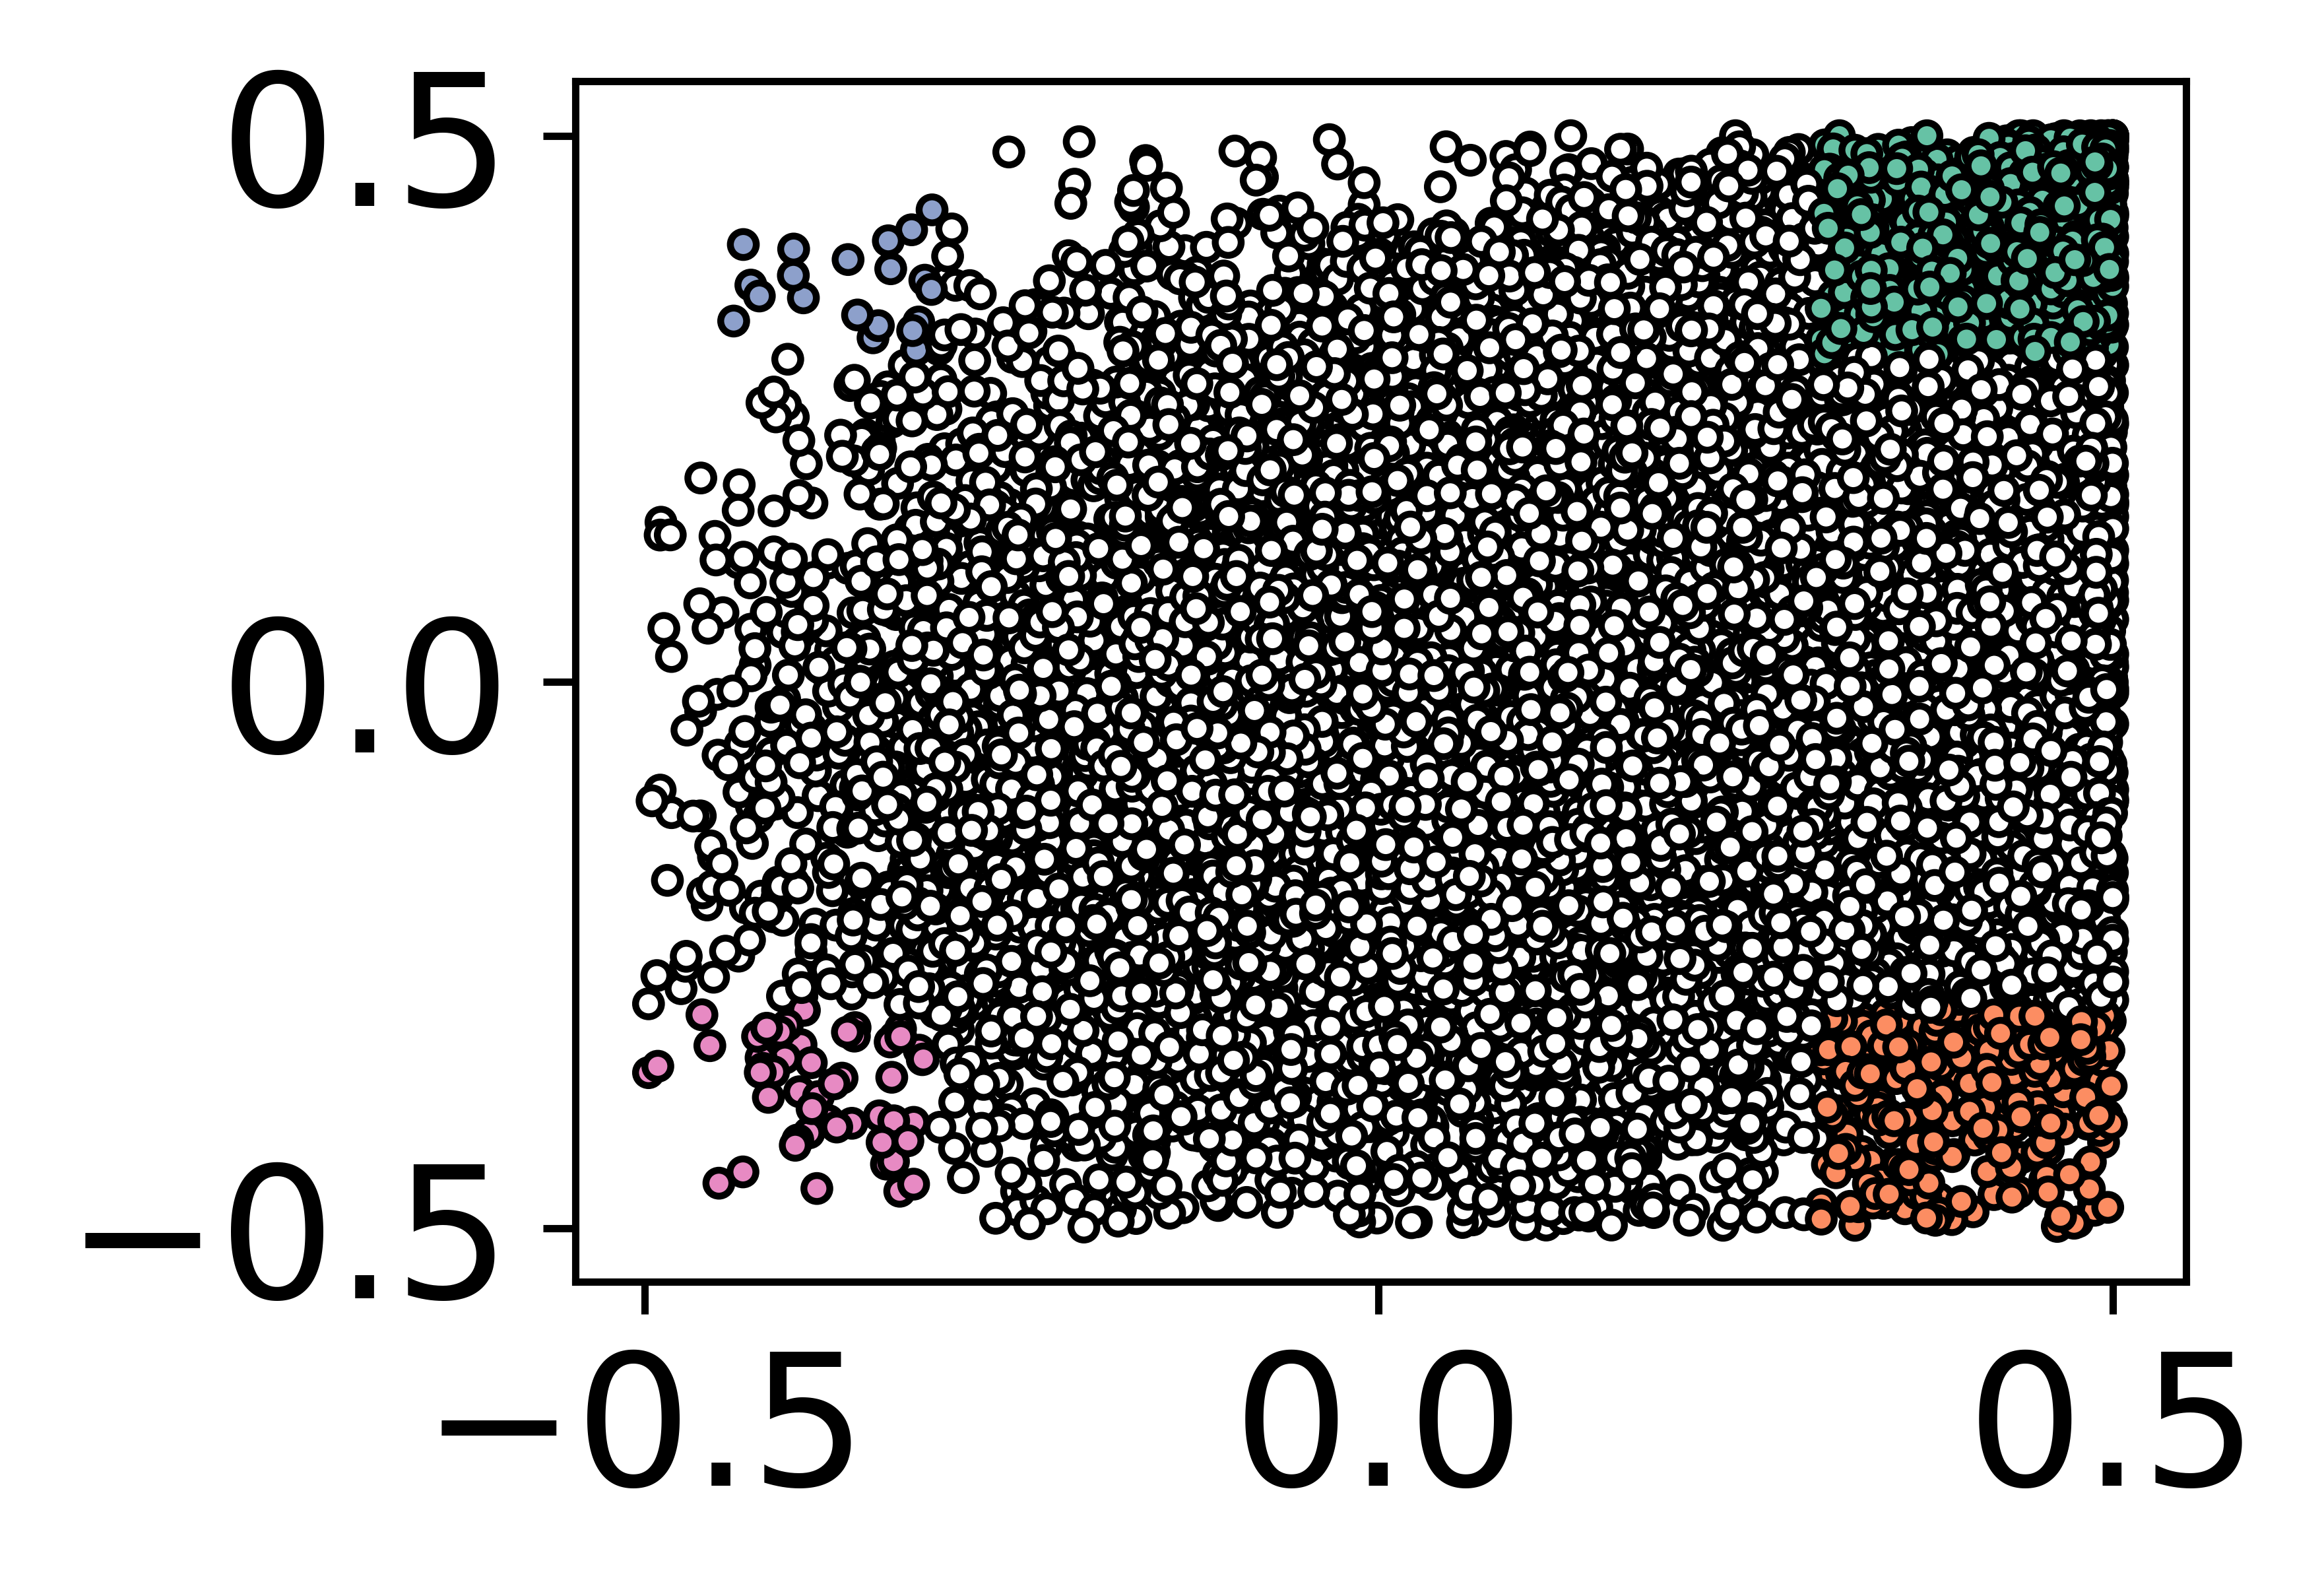

In [53]:
osi = orientation_selectivity_index(avg_responses,stim_bins[:-1])#angle_selectivity_index(avg_responses_lowres,4)#
dsi = direction_selectivity_index(avg_responses,stim_bins[:-1])#angle_selectivity_index(avg_responses_lowres,2)#


osi_centered = osi-0.5
dsi_centered = dsi-0.5
si_2d = np.vstack([osi_centered,dsi_centered]).T
xy_boundaries = (0.3,0.3)#np.mean(si_2d,1)#

n_clusters = 4
#si_clusters = si_clustering(avg_responses_lowres,[2,4],n_clusters)

#angle_invar_clusters = angle_invar_clustering(avg_responses_lowres.T,n_clusters)#list(np.arange(2,16)))
#print(np.shape(angle_invar_clusters[0]))
#clust_labels = si_clusters#angle_invar_clusters[1]

N_sub = 101
neuron_clusters = []
unimodal_neurons = np.where(np.logical_and(osi_centered>xy_boundaries[0],dsi_centered>xy_boundaries[1]))[0]#clust_labels==0)[0]#
bimodal_neurons = np.where(np.logical_and(osi_centered>xy_boundaries[0],dsi_centered<-xy_boundaries[1]))[0]#clust_labels==1)[0]#
nonlinear_neurons = np.where(np.logical_and(osi_centered<-xy_boundaries[0],dsi_centered>xy_boundaries[1]))[0]#clust_labels==2)[0]#
noise_neurons = np.where(np.logical_and(osi_centered<-xy_boundaries[0],dsi_centered<-xy_boundaries[1]))[0]#clust_labels==3)[0]#
#unimodal_neurons = unimodal_neurons[np.argsort(np.linalg.norm(si_2d[unimodal_neurons],ord=1,axis=1))[-N_sub:]]
#bimodal_neurons = bimodal_neurons[np.argsort(np.linalg.norm(si_2d[bimodal_neurons],ord=1,axis=1))[-N_sub:]]
#nonlinear_neurons = nonlinear_neurons[np.argsort(np.linalg.norm(si_2d[nonlinear_neurons],ord=1,axis=1))[-N_sub:]]
#noise_neurons = noise_neurons[np.argsort(np.linalg.norm(si_2d[noise_neurons],ord=1,axis=1))[-N_sub:]]
print(len(unimodal_neurons))
print(len(bimodal_neurons))
print(len(nonlinear_neurons))
print(len(noise_neurons))
neuron_clusters = [unimodal_neurons,bimodal_neurons,nonlinear_neurons,noise_neurons]
color_labels = np.ones([len(osi_centered),3])
#clust_means = np.zeros(n_clusters)
#for i in range(n_clusters):
#    neuron_clusters.append(np.where(clust_labels==i)[0])
#    clust_means[i] = (np.mean(angle_invar_clusters[0][neuron_clusters[-1]],0)-np.mean(angle_invar_clusters[0][neuron_clusters[-1]]))[int(len(stim_bins_lowres)/2)]
#cluster_reorder = np.argsort(clust_means)
#neuron_clusters = [neuron_clusters[i] for i in cluster_reorder]
for i in range(n_clusters):
    color_labels[neuron_clusters[i]] = cust_cmap2.colors[i]
plt.rc('axes', axisbelow=True)
font = {'size'   : 20}
matplotlib.rc('font', **font)

plt.figure(dpi=1000,figsize=(8*cm,6*cm))
#plt.axhline(y=0, color='k')
#plt.axvline(x=0, color='k')
#plt.axhline(y=xy_boundaries[1], color='k')
#plt.axvline(x=xy_boundaries[0], color='k')
#plt.axvline(x=-xy_boundaries[0], color='k')
#plt.axhline(y=-xy_boundaries[1], color='k')
plt.scatter(osi_centered,dsi_centered,s=8,c=color_labels,edgecolor='black',linewidths=0.75)
#plt.xlabel('OSI')
#plt.ylabel('DSI')

#plt.savefig('/Users/constb/Figures/NeuralHomology/cell_classification_'+str(N_sub)+'.png',transparent=True,dpi=1000, bbox_inches='tight')

In [54]:
von_mises_tuning_curves = np.zeros(np.shape(avg_responses))
von_mises_1st = np.zeros(np.shape(avg_responses))
von_mises_2nd = np.zeros(np.shape(avg_responses))
tuning_parameters = np.zeros([len(avg_responses.T),7])
r2_scores = np.zeros(len(avg_responses.T))
for n in range(len(avg_responses.T)):
    f, f1, f2, params = fit_von_mises(stim_bins[:-1],avg_responses[:,n]/np.linalg.norm(avg_responses[:,n]))
    von_mises_tuning_curves[:,n] = f*np.linalg.norm(avg_responses[:,n])
    von_mises_1st[:,n] = f1
    von_mises_2nd[:,n] = f2
    tuning_parameters[n] = params
    r2_scores[n] = r2_score(avg_responses[:,n],von_mises_tuning_curves[:,n])
    if n%500==0:
        print(n)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500


(-0.3115904282406594,
 6.543398993053847,
 -0.7122721757207598,
 14.957715690135956)

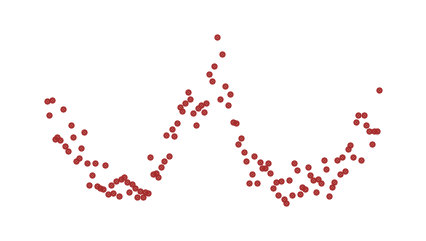

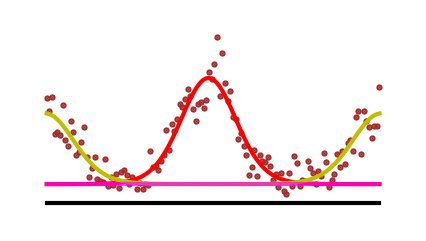

In [55]:
#example cell fitting plots
indx=132
sel_cell = avg_responses[:,r2_scores>0.8][:,indx]
sel_fit_1 = np.linalg.norm(avg_responses[:,r2_scores>0.8][:,indx])*von_mises_1st[:,r2_scores>0.8][:,indx]#von_mises_tuning_curves[:,r2_scores>0.8][:,indx]
sel_fit_2 = np.linalg.norm(avg_responses[:,r2_scores>0.8][:,indx])*von_mises_2nd[:,r2_scores>0.8][:,indx]#von_mises_tuning_curves[:,r2_scores>0.8][:,indx]
sel_baseline = np.linalg.norm(avg_responses[:,r2_scores>0.8][:,indx])*tuning_parameters[r2_scores>0.8,-1][indx]*np.ones(len(stim_bins[:-1]))

plt.figure(figsize=(4*cm,2*cm),dpi=300)
plt.plot(stim_bins[:-1], sel_cell, '.',color='brown',markersize=1)
plt.axis('off')
#plt.savefig('/Users/constb/Figures/NeuralHomology/rand_cell.png',transparent=True,dpi=1000, bbox_inches='tight')

plt.figure(figsize=(4*cm,2*cm),dpi=300)
plt.plot(stim_bins[:-1], sel_cell, '.',color='brown', markersize=1)
plt.plot(stim_bins[:-1], sel_fit_1, 'r',lw=1)
plt.plot(stim_bins[:-1], sel_fit_2, 'y',lw=1)
plt.plot(stim_bins[:-1],sel_baseline,'magenta',alpha=0.7,lw=1)
plt.plot(stim_bins[:-1],np.zeros(len(stim_bins[:-1])),'black',lw=1)
plt.axis('off')
#plt.savefig('/Users/constb/Figures/NeuralHomology/rand_cell_fit.png',transparent=True,dpi=1000, bbox_inches='tight')


0.5443124214271764


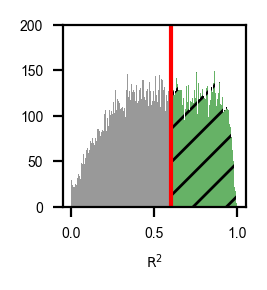

In [134]:
r2_thresh = 0.6
plt.rcParams.update({'font.size': 5})

plt.figure(figsize=(3*cm,3*cm),dpi=200)
plt.hist(r2_scores[r2_scores<r2_thresh],np.linspace(0,1,200),color='black',alpha=0.4)
plt.hist(r2_scores[r2_scores>=r2_thresh],np.linspace(0,1,200),color='green',alpha=0.6,hatch='//')

plt.vlines(r2_thresh,0,200,'red')
plt.ylim(0,200)
plt.xlabel('$R^2$')
plt.savefig('/Users/constb/Figures/NeuralHomology/fit_r2_hist.png',transparent=True,dpi=1000, bbox_inches='tight')

print(np.median(r2_scores))

/var/folders/16/v7n9r3kd5jb_n_2jxmxrldyw0000gp/T/ipykernel_23999/23889121.py:9: RuntimeWarning: invalid value encountered in arccos
  widths1 = 2*np.arccos(np.log((np.exp(tuning_parameters[r2_scores>r2_thresh,2])+np.exp(-tuning_parameters[r2_scores>r2_thresh,2]))/2))
/var/folders/16/v7n9r3kd5jb_n_2jxmxrldyw0000gp/T/ipykernel_23999/23889121.py:10: RuntimeWarning: invalid value encountered in arccos
  widths2 = 2*np.arccos(np.log((np.exp(tuning_parameters[r2_scores>r2_thresh,3])+np.exp(-tuning_parameters[r2_scores>r2_thresh,3]))/2))
/var/folders/16/v7n9r3kd5jb_n_2jxmxrldyw0000gp/T/ipykernel_23999/23889121.py:11: RuntimeWarning: Mean of empty slice
  widths = np.nanmean(np.vstack([widths1, widths2]),0)
/var/folders/16/v7n9r3kd5jb_n_2jxmxrldyw0000gp/T/ipykernel_23999/23889121.py:14: RuntimeWarning: divide by zero encountered in true_divide
  peak_ratio = np.max(vm1_selected,0)/np.max(vm2_selected,0)
/var/folders/16/v7n9r3kd5jb_n_2jxmxrldyw0000gp/T/ipykernel_23999/23889121.py:15: RuntimeWar

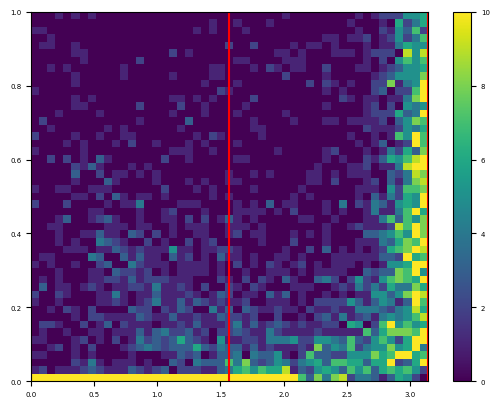

In [57]:

selected_tun_curves = avg_responses[:,r2_scores>r2_thresh]
selected_fit_curves = von_mises_tuning_curves[:,r2_scores>r2_thresh]
selected_parameters = tuning_parameters[r2_scores>r2_thresh,:]
vm1_selected = von_mises_1st[:,r2_scores>r2_thresh] - np.mean(von_mises_1st[:,r2_scores>r2_thresh],0)
vm1_selected[vm1_selected<0] = 0
vm2_selected = von_mises_2nd[:,r2_scores>r2_thresh] - np.mean(von_mises_2nd[:,r2_scores>r2_thresh],0)
vm2_selected[vm2_selected<0] = 0

widths1 = 2*np.arccos(np.log((np.exp(tuning_parameters[r2_scores>r2_thresh,2])+np.exp(-tuning_parameters[r2_scores>r2_thresh,2]))/2))
widths2 = 2*np.arccos(np.log((np.exp(tuning_parameters[r2_scores>r2_thresh,3])+np.exp(-tuning_parameters[r2_scores>r2_thresh,3]))/2))
widths = np.nanmean(np.vstack([widths1, widths2]),0)
#plt.hist(widths1[r2_scores>r2_thresh],100)

peak_ratio = np.max(vm1_selected,0)/np.max(vm2_selected,0)
peak_ratio_inv = 1/peak_ratio
peak_ratio = np.min(np.vstack([peak_ratio, peak_ratio_inv]),0)

angle_difference = np.arccos(np.cos(selected_parameters[:,0]-selected_parameters[:,1]))


from matplotlib.colors import LogNorm

plt.figure()
h, angle_edges, peak_edges = np.histogram2d(angle_difference, peak_ratio, bins=[np.linspace(0,np.pi,50),np.linspace(0,1,50)])
_ = plt.pcolormesh(angle_edges,peak_edges,h.T, rasterized=True, vmax=10)#, shading='gouraud')
plt.vlines([0,np.pi/2,np.pi],[0,0,0],[1,1,1],'r')
#plt.yscale('log')
plt.colorbar()

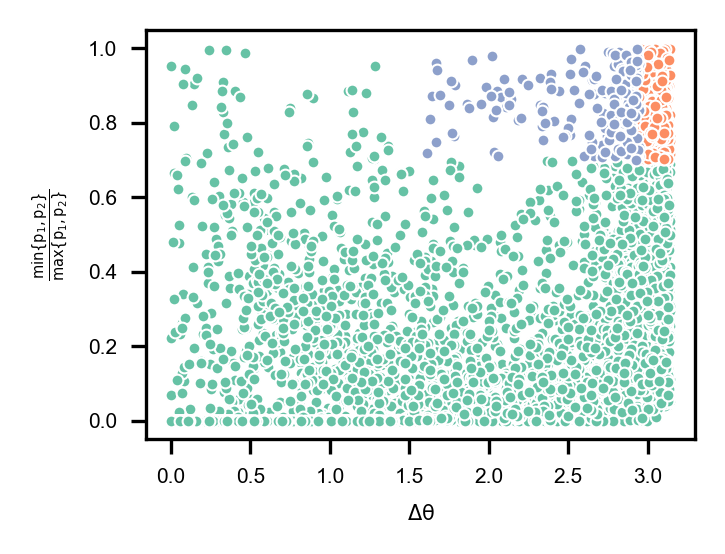

In [132]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 5})
angle_spacing = np.pi/16
min_peak_ratio = 0.7
min_spacing = np.pi/2
edges_centers = np.arange(min_spacing,np.pi+angle_spacing,2*angle_spacing)#[:-1]
unimod = np.where(np.logical_or(peak_ratio<min_peak_ratio, angle_difference<min_spacing-angle_spacing))[0]
bimod = np.where(np.logical_and(peak_ratio>min_peak_ratio, np.logical_and(angle_difference>edges_centers[0], angle_difference<edges_centers[-1]-angle_spacing)))[0]
lastmod = np.where(np.logical_and(peak_ratio>min_peak_ratio, np.logical_and(angle_difference>edges_centers[-1]-angle_spacing, angle_difference<edges_centers[-1]+angle_spacing)))[0]
cell_labels_list = [unimod,lastmod, bimod ]
clust_responses = [selected_tun_curves[:,unimod], selected_tun_curves[:,lastmod], selected_tun_curves[:,bimod] ]
clust_responses_fitted = [selected_fit_curves[:,unimod], selected_fit_curves[:,lastmod], selected_fit_curves[:,bimod]]

plt.figure(dpi=300,figsize=(6*cm,4.5*cm))
for count, i in enumerate(cell_labels_list):
    plt.scatter(angle_difference[i], peak_ratio[i],s=8,color=cust_cmap2.colors[count], edgecolor='white',linewidths=0.5)

plt.xlabel('$\Delta \\theta$')
plt.ylabel('$\\frac{\min\{p_1,p_2\}}{\max\{p_1,p_2\}}$')
plt.savefig('/Users/constb/Figures/NeuralHomology/von_Mises_classes.png',transparent=True,dpi=1000, bbox_inches='tight')


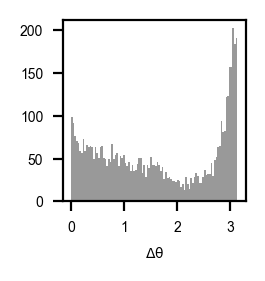

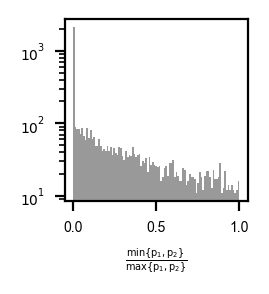

In [122]:
plt.figure(figsize=(3*cm,3*cm),dpi=200)
#for i in cell_labels_list:
plt.hist(angle_difference,np.linspace(0,np.pi,100),color='black',alpha=0.4)
plt.xlabel('$\Delta \\theta$')
#plt.savefig('/Users/constb/Figures/NeuralHomology/angle_diff_hist.png',transparent=True,dpi=1000, bbox_inches='tight')

plt.figure(figsize=(3*cm,3*cm),dpi=200)
#for i in cell_labels_list:
plt.hist(peak_ratio,np.linspace(0,1,100),color='black',alpha=0.4)
plt.xlabel('$\\frac{\min\{p_1,p_2\}}{\max\{p_1,p_2\}}$')
plt.yscale('log')
#plt.savefig('/Users/constb/Figures/NeuralHomology/peak_ratio_hist.png',transparent=True,dpi=1000, bbox_inches='tight')


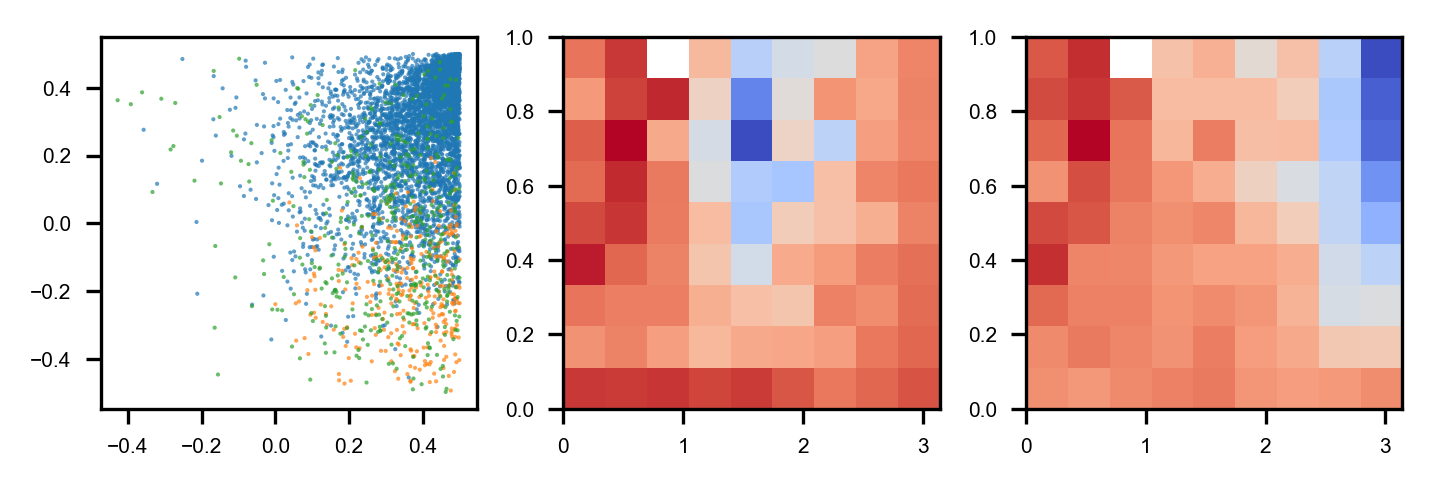

In [123]:
from scipy.stats import binned_statistic_2d

von_mises_osi = orientation_selectivity_index(selected_tun_curves,stim_bins[:-1])-0.5
von_mises_dsi = direction_selectivity_index(selected_tun_curves,stim_bins[:-1])-0.5

nbins = 10
angle_bins = np.linspace(0,np.pi,nbins)
peak_bins = np.linspace(0,1,nbins)
mean_osi = binned_statistic_2d(angle_difference, peak_ratio, von_mises_osi, statistic=np.nanmean, bins=[angle_bins, peak_bins])
mean_dsi = binned_statistic_2d(angle_difference, peak_ratio, von_mises_dsi, statistic=np.nanmean, bins=[angle_bins, peak_bins])

plt.figure(dpi=300,figsize=(12*cm,4*cm))
plt.subplot(1,3,1)
for i in cell_labels_list:
    plt.scatter(von_mises_osi[i],von_mises_dsi[i], s = 1,alpha=0.7, edgecolor='None')
plt.subplot(1,3,2)
plt.pcolormesh(angle_bins, peak_bins, mean_osi.statistic.T,rasterized=True,cmap='coolwarm')
plt.subplot(1,3,3)
plt.pcolormesh(angle_bins, peak_bins, mean_dsi.statistic.T,rasterized=True, cmap='coolwarm')
#for i in cell_labels_list:
#    plt.subplot(121)
#    plt.scatter(angle_difference[i], peak_ratio[i],c=von_mises_osi[i],s=8,linewidths=0.5,vmin=0,vmax=1)
#    plt.title('OSI')
#    plt.subplot(122)
#    plt.scatter(angle_difference[i], peak_ratio[i],c=von_mises_dsi[i],s=8,linewidths=0.5,vmin=0,vmax=1)
#    plt.title('DSI')
#plt.vlines([0,np.pi/2,np.pi],[0,0,0],[1,1,1],'k')
#plt.xlabel('angle difference')
#plt.ylabel('peak ratio')
plt.tight_layout()

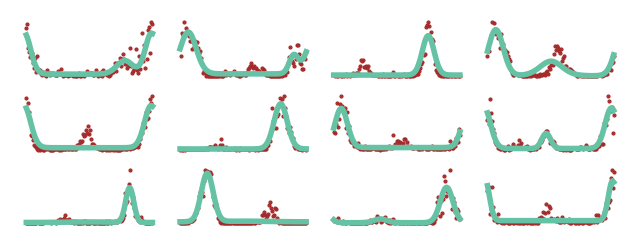

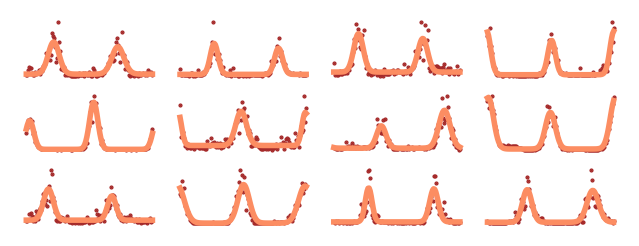

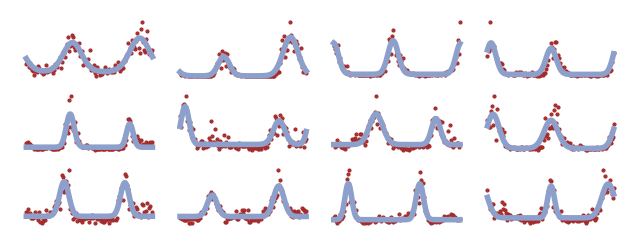

In [ ]:
default_colors = plt.get_cmap("tab10").colors
for n in range(len(clust_responses)):
    plt.figure(dpi=200,figsize=(8*cm,3*cm))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.plot(clust_responses[n][:,i],'.',markersize=1,color='brown')
        plt.plot(clust_responses_fitted[n][:,i],color=cust_cmap2.colors[n],lw=2)
        #plt.xticks([])
        #plt.yticks([])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/Users/constb/Figures/NeuralHomology/example_fits_'+str(n)+'.png',transparent=True,dpi=1000, bbox_inches='tight')


1 significant 1-cocycles
0 significant 1-cocycles
1 significant 1-cocycles


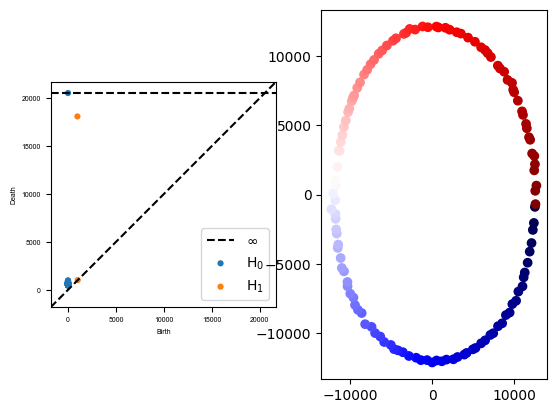

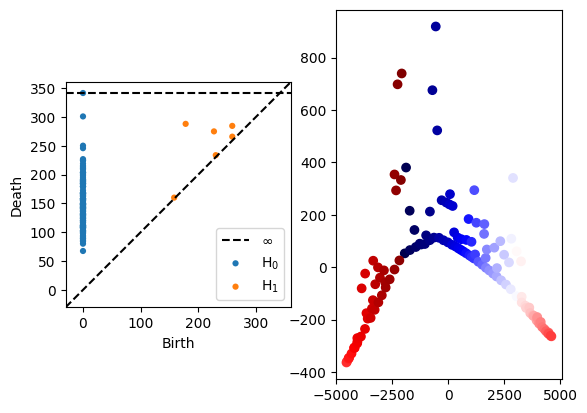

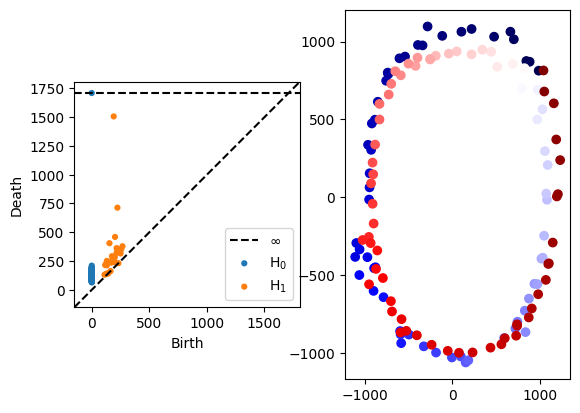

In [107]:
metric_used = geodesic_knn(k=4,adaptive=True).fit#pairwise_distances#geodesic#
reducer = Isomap(n_neighbors=4,n_components=2,metric='precomputed')
homs = []
for i, resps in enumerate(clust_responses):
    plt.figure()  
    pvalue_hom = Homologizer.perm_test(resps,metric_used,n_perms=100,pval=99.99)
    homs.append(Homologizer(resps,metric_used,False,dim_red,[1,None]))
    mfld = reducer.fit_transform(homs[i][0])
    plt.subplot(1,2,1)
    plot_diagrams(homs[i][1])
    plt.subplot(1,2,2)
    plt.scatter(mfld[:,0],mfld[:,1],c=np.linspace(0,1,len(mfld[:,0])),cmap='seismic')
    #Homologizer.barcode_plot(homs[-1][1],2)
    #plt.imshow(homs[i][0])
    #plt.colorbar()
    #BA.plotCocycle2D(homs[-1][0],ori_mfld[:,:2],900,labels=stim_bins_degrees,node_cmap='seismic')
    #plt.title(edges_spacing[i])

In [ ]:
print(DO_reg.score(X_test[:,unimodal_neurons],y_test))
print(O_reg.score(X_test[:,bimodal_neurons],y_test))
print(D_reg.score(X_test[:,nonlinear_neurons],y_test))
print(untuned_reg.score(X_test[:,noise_neurons],y_test))

plt.figure(dpi=200)
plt.subplot(2,2,1)
plt.plot(DO_pred,y_test,'.')


plt.subplot(2,2,2)
plt.plot(O_pred,y_test,'.')


plt.subplot(2,2,3)
plt.plot(D_pred,y_test,'.')


plt.subplot(2,2,4)
plt.plot(untuned_pred,y_test,'.')


In [ ]:
from dreimac import CircularCoords, ProjectiveCoords
X_train, X_test, y_train, y_test = train_test_split(
     avg_responses, np.arange(0,len(avg_responses)), test_size=0.2)

#X_mfld = PCA(n_components=2).fit_transform(X_train)

cc = CircularCoords(avg_responses,126)
#pc = ProjectiveCoords(avg_responses,100)

f1 = cc.get_coordinates(perc=1, cocycle_idx=[0])
f2 = cc.get_coordinates(perc=1, cocycle_idx=[1])
#f = phi

plt.scatter(ori_mfld[:, 0], ori_mfld[:, 1], c=f1+f2, cmap='magma_r')
plt.figure()
plt.plot(f1)
plt.plot(f2)